In [1]:
import os
os.chdir('..')

In [2]:
from model.network import Converter
import matplotlib.pyplot as plt

wandb: WARNING import wandb.keras called before import keras or import tensorflow.keras.  This can lead to a version mismatch, W&B now assumes tensorflow.keras
Using TensorFlow backend.


In [3]:
import os
import pickle
from pathlib import Path
import re

import numpy as np
import pandas as pd
import tensorflow as tf
import lpips_tf

from keras import backend as K
from keras import optimizers, losses, regularizers
from keras.layers import Conv2D, Dense, UpSampling2D, LeakyReLU, Activation
from keras.layers import Layer, Input, Reshape, Lambda, Flatten, Concatenate, Embedding, GaussianNoise
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from keras.applications import vgg16
from keras_lr_multiplier import LRMultiplier
from assets import AssetManager

from tqdm import tqdm
import cv2

In [4]:
model_name = 'smallnorb_no_adain_2'
assets = AssetManager('results')
converter = Converter.load( assets.get_model_dir(model_name), include_encoders=True)

def pred_imgs(imgs):
    curr_imgs = np.stack(imgs, axis=0)
    content_codes = converter.content_encoder.predict(curr_imgs)
    class_codes = converter.class_encoder.predict(curr_imgs)
    #class_adain_params = converter.class_modulation.predict(class_codes)
    return content_codes, class_codes# class_adain_params

loading models...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



vgg arch:
Model: "vgg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
vgg_normalization_1 (VggNorm (None, 64, 64, 3)         0         
_________________________________________________________________
model_1 (Model)              [(None, 64, 64, 64), (Non 14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [5]:
base_dir = r'data\small_norb_lord'

In [6]:
azimuths = []
elevations = []
lightings = []
lt_rts = []
classes = []
img_paths = []

regex = re.compile('azimuth(\d+)_elevation(\d+)_lighting(\d+)_(\w+).jpg')
for category in tqdm(os.listdir(base_dir)):
    for instance in os.listdir(os.path.join(base_dir, category)):
        for file_name in os.listdir(os.path.join(base_dir, category, instance)):
            img_path = os.path.join(base_dir, category, instance, file_name)
            azimuth, elevation, lighting, lt_rt = regex.match(file_name).groups()

            class_id = (int(category) * 10) + int(instance)
            azimuths.append(int(azimuth))
            elevations.append(int(elevation))
            lightings.append(int(lighting))
            lt_rts.append(lt_rt)
            classes.append(class_id)
            img_paths.append(img_path)
            

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.17it/s]


In [7]:
df = pd.DataFrame({
    'azimuth': azimuths,
    'elevation': elevations,
    'lighting': lightings,
    'lt_rt': lt_rts,
    'classe': classes,
    'img_path': img_paths,
})

In [8]:
df.describe()

,azimuth,elevation,lighting,classe
count,48600.000000,48600.000000,48600.000000,48600.000000
mean,8.500000,4.000000,2.500000,24.500000
std,5.188181,2.582015,1.707843,14.431018
min,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2.000000,1.000000,12.000000
50%,8.500000,4.000000,2.500000,24.500000
75%,13.000000,6.000000,4.000000,37.000000
max,17.000000,8.000000,5.000000,49.000000


In [9]:
# df[(df.classe == 0) & (df.azimuth ==0) & (df.elevation == 0)]['img_path']

In [10]:
# plt.rcParams["figure.figsize"] = (20,2)
# for i, img_path in enumerate(df[(df.classe == 0) & (df.azimuth ==0) & (df.elevation == 0)]['img_path']):
#     plt.subplot(1, 10, i+1)
#     plt.imshow(plt.imread(img_path))
# plt.suptitle('Lighting')
# plt.show()

In [11]:
# plt.rcParams["figure.figsize"] = (20,2)
# for i, img_path in enumerate(df[(df.classe == 0) & (df.elevation == 0) & (df.lighting == 0)]['img_path'][:10]):
#     plt.subplot(1, 10, i+1)
#     plt.imshow(plt.imread(img_path))
# plt.suptitle('Azimuth')
# plt.show()

In [12]:
# plt.rcParams["figure.figsize"] = (20,2)
# for i, img_path in enumerate(df[(df.classe == 0) & (df.azimuth ==0) & (df.lighting == 0)]['img_path'][:10]):
#     plt.subplot(1, 10, i+1)
#     plt.imshow(plt.imread(img_path))
# plt.suptitle('Elevation')
# plt.show()

In [13]:
df = df.sample(frac=1).reset_index(drop=True)

In [14]:
fxd_content = [df[df.lighting == i]['img_path'].iloc[0] for i in range(6)] # df[(df.azimuth ==0) & (df.elevation == 0) & (df.lighting == 0)]['img_path'][:10]
fxd_class = df[df.classe == 0]['img_path'][:10]
l2li = lambda x: [np.expand_dims(cv2.cvtColor(cv2.resize(plt.imread(i), dsize=(64, 64)), cv2.COLOR_BGR2GRAY), axis=2).astype(np.float32) / 255.0 for i in x]

fxd_content_img = l2li(fxd_content)
fxd_class_img = l2li(fxd_class)

In [15]:
fxd_content_cnt, fxd_content_cls = pred_imgs(fxd_content_img)
fxd_class_cnt, fxd_class_cls = pred_imgs(fxd_class_img)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.16s/it]


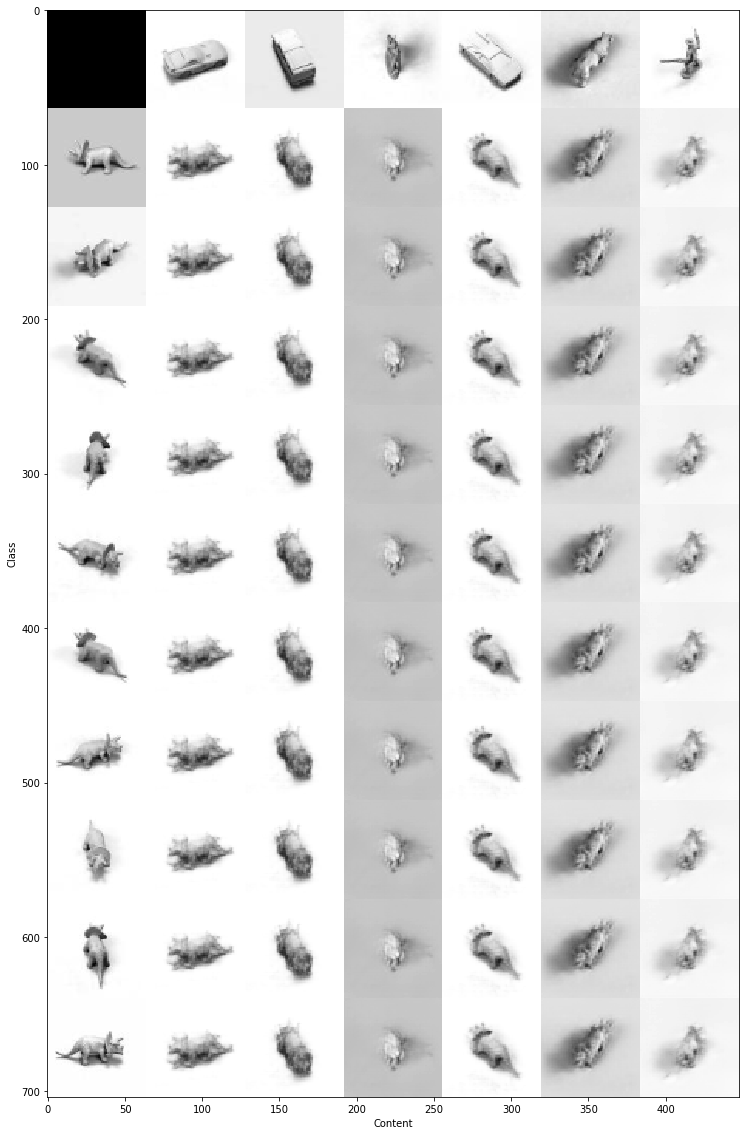

In [16]:
plt.rcParams["figure.figsize"] = (20,20)
blank = np.zeros_like(fxd_content_img[0])
output = [np.concatenate([blank] + list(fxd_content_img), axis=1)]
for i in tqdm(range(10)):
    generated_imgs = [
        converter.generator.predict([fxd_content_cnt[[j]], fxd_class_cls[[i]]])[0]
        for j in range(6)
    ]

    converted_imgs = [fxd_class_img[i]] + generated_imgs

    output.append(np.concatenate(converted_imgs, axis=1))

merged_img = np.concatenate(output, axis=0)

plt.xlabel('Content')
plt.ylabel('Class')
plt.imshow(np.squeeze(merged_img), cmap='gray') # TODO save to file